# Maritime Trade: Train 2018 - 2019 XGBoost GPU
## Hyperopt Hyperparameter Optimization

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install category_encoders
!pip install xgboost==1.5.2
!pip install eli5
!pip install shap
import os
import random
import numpy as np
import warnings
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor, plot_importance
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import csv
from datetime import datetime, timedelta
from timeit import default_timer as timer
import ast
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
import webbrowser
from eli5.formatters import format_as_dataframe
import shap
warnings.filterwarnings('ignore')
my_dpi = 96
print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 677 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 173.6 MB 9.3 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 2.1 MB/s 
     |████████████████████████████████| 133 kB 27.6 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=183ffbdca73a46484ac73cc21bd38a8cd1c8c5b8f5622d51f9a3fbeb581d4ad8
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Fo

In [ ]:
# Set seed
seed_value = 42
os.environ['xgbGPU_train1819'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final.csv', low_memory=False)
df = df.drop_duplicates()
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna()
        & df.State_Closure_EA_Diff.notna()]

# Subset years for training
df = df.loc[(df['Year'] >= 2018) & (df['Year'] < 2020)]

# Examine distribution of year data
df[['Year']].value_counts()

Year  
2018.0    3080375
2019.0    2978984
dtype: int64

In [ ]:
# X,y for encoding
X = df.drop(['Metric_Tons', 'DateTime'], axis=1)
y = df.loc[:, ['Metric_Tons']]

del df

In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=X.Year,
                                                    random_state=seed_value)

In [ ]:
# Encode variables using ranking - ordinal
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_train = ce_ord.fit_transform(X_train)
X_test = ce_ord.fit_transform(X_test)

# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# MinMax Scaling
mn = MinMaxScaler()
X_train = pd.DataFrame(mn.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(mn.transform(X_test), columns=X_test.columns)

## 100 Trials 10-Fold Cross Validation

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions


In [ ]:
# Define the number of trials
NUM_EVAL = 100

# Set same k-folds for reproducibility
kfolds = KFold(n_splits=10, shuffle=True, random_state=seed_value)

xgb_tune_kwargs= {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 500, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'subsample': hp.uniform('subsample', 0.25, 0.75),
    'gamma': hp.uniform('gamma', 0, 9),
    'learning_rate': hp.uniform('learning_rate', 1e-4, 0.3),
    'reg_alpha': hp.choice('reg_alpha', np.arange(0, 30, dtype=int)),
    'reg_lambda': hp.uniform('reg_lambda', 0, 3),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.05, 0.5),
    'min_child_weight': hp.choice('min_child_weight', np.arange(0, 10,
                                                                dtype=int))
    }

In [ ]:
# Define a function for optimization of hyperparameters
def xgb_hpo(config):

    """
    Objective function to tune a `XGBoostRegressor` model.
    """

    # Keep track of evaluations
    global ITERATION

    ITERATION += 1

    # Parameters that are integers to remain integers
    config['n_estimators'] = int(config['n_estimators'])

    # Start hyperopt at 3 for max_depth
    config['max_depth'] = int(config['max_depth']) + 3

    # Define model type
    xgb = XGBRegressor(objective='reg:squarederror',
                       booster='gbtree',
                       tree_method='gpu_hist',
                       scale_pos_weight=1,
                       use_label_encoder=False,
                       random_state=seed_value,
                       verbosity=0,
                       **config)

    # Start timer for each trial
    start = timer()

    # Perform k_folds cross validation to find lower error
    scores = -cross_val_score(xgb, X_train, y_train,
                              scoring='neg_root_mean_squared_error',
                              cv=kfolds)
    run_time = timer() - start

    # Extract the best score
    rmse = np.mean(scores)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([rmse, config, ITERATION, run_time])

    return {'loss': rmse, 'params': config, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

In [ ]:
# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save first results
out_file = 'XGB_HPO_train1819_100_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_trials,
                  rstate=np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-18 00:28:18.583642
100%|██████████| 100/100 [5:32:07<00:00, 199.27s/it, best loss: 350.7266932530201]
Start Time           2022-02-18 00:28:18.583642
End Time             2022-02-18 06:00:25.641074
5:32:07


In [ ]:
# Sort the trials with lowest loss (lowest RMSE) first
bayesOpt_trials_results = sorted(bayesOpt_trials.results,
                                 key=lambda x: x['loss'])
print('Top two trials with the lowest loss (lowest RMSE)')
print(bayesOpt_trials_results[:2])

Top two trials with the lowest loss (lowest RMSE)
[{'loss': 350.7266932530201, 'params': {'colsample_bylevel': 0.3378549263629474, 'colsample_bytree': 0.6662531613988424, 'gamma': 0.8483219167001996, 'learning_rate': 0.040743703542436435, 'max_depth': 12, 'min_child_weight': 0, 'n_estimators': 485, 'reg_alpha': 27, 'reg_lambda': 2.519019242361794, 'subsample': 0.5053571891260848}, 'iteration': 70, 'train_time': 513.3204846110002, 'status': 'ok'}, {'loss': 350.9795631757681, 'params': {'colsample_bylevel': 0.30193748084340205, 'colsample_bytree': 0.8446703029143787, 'gamma': 1.635129876708801, 'learning_rate': 0.07385029741641519, 'max_depth': 12, 'min_child_weight': 0, 'n_estimators': 249, 'reg_alpha': 8, 'reg_lambda': 2.6630358240486935, 'subsample': 0.545484238488734}, 'iteration': 84, 'train_time': 300.10529975999816, 'status': 'ok'}]


In [ ]:
# Access results
results = pd.read_csv('XGB_HPO_train1819_100_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = XGBRegressor(objective='reg:squarederror',
                                booster='gbtree',
                                tree_method='gpu_hist',
                                scale_pos_weight=1,
                                use_label_encoder=False,
                                random_state=seed_value,
                                verbosity=0,
                                **best_bayes_params)
# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_HPO_train1819_100_GPU.pkl'

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_HPO_train1819_100_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO Train train1819 100 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))


Model Metrics for XGBoost HPO Train train1819 100 GPU trials
MAE train: 19.136, test: 27.221
MSE train: 73281.525, test: 178586.949
RMSE train: 270.706, test: 422.595
R^2 train: 0.796, test: 0.465


In [ ]:
# Evaluate on the testing data
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test,
                                                                                                            y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 178586.92644 MSE on the test set.
This was achieved after 70 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0,
                                                                      'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, =:] = list(ast.literal_eval(params).values())

bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_XGB_HPO_train1819_100_GPU.csv',
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

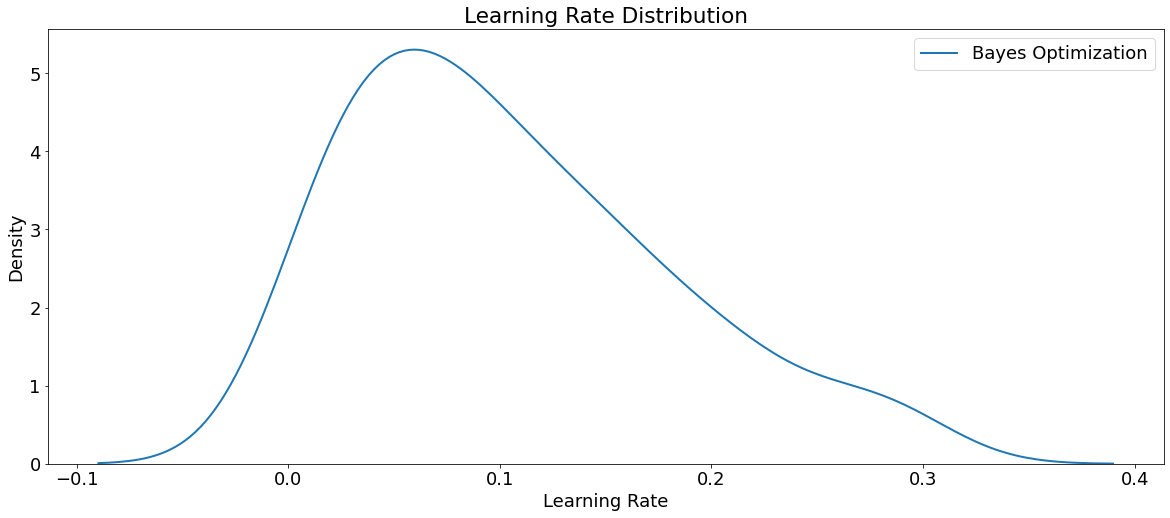

In [ ]:
# Density plots of the learning rate distributions
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization',
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

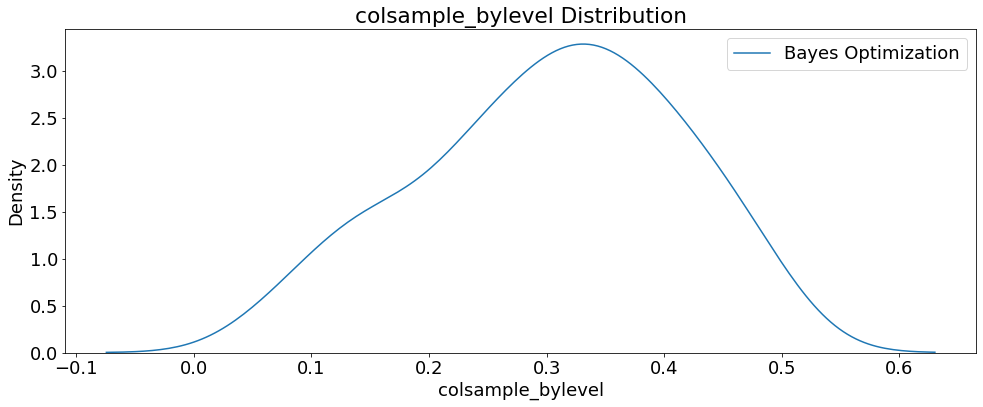

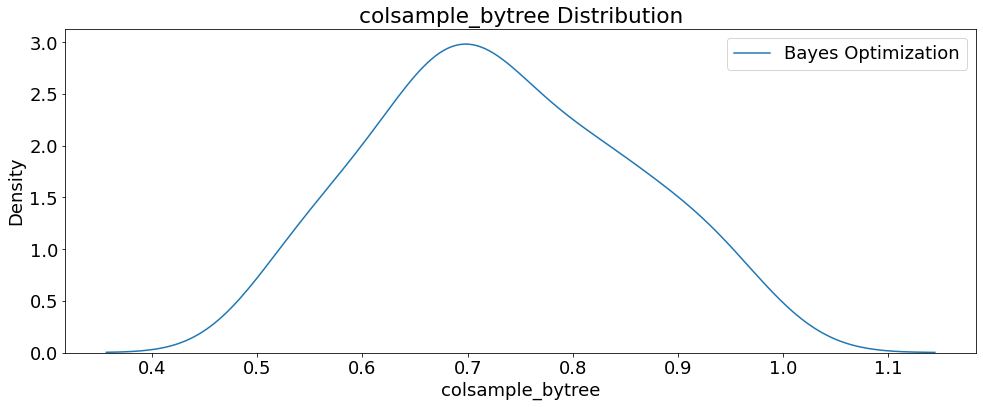

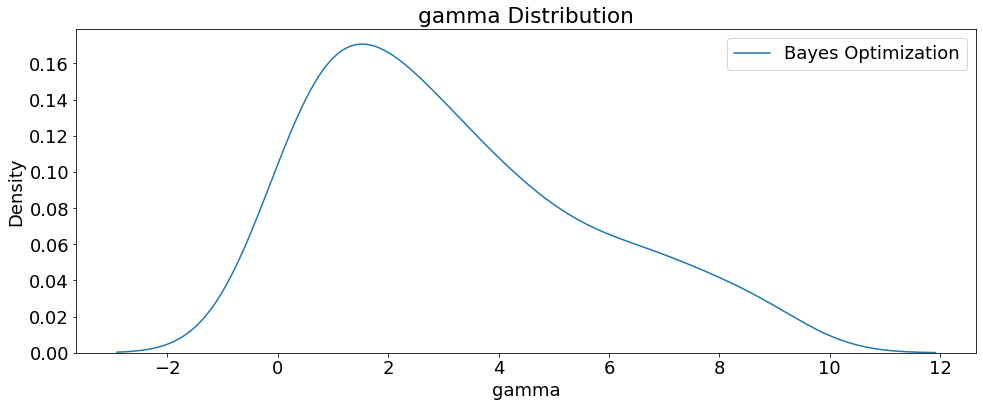

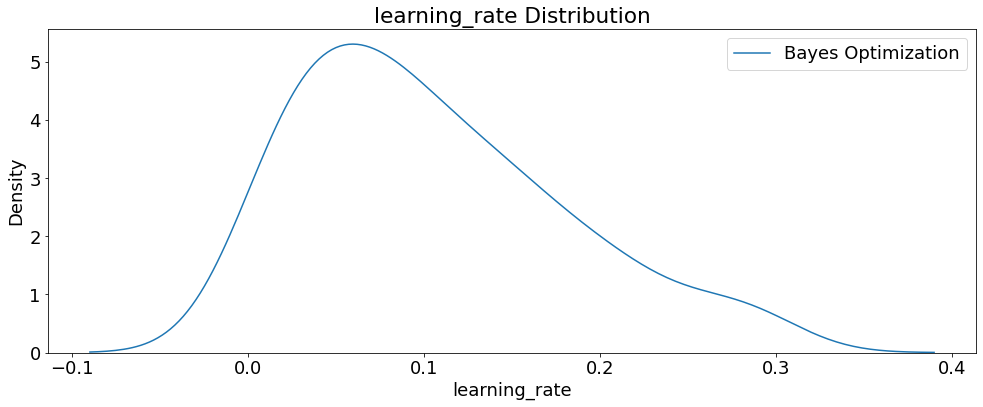

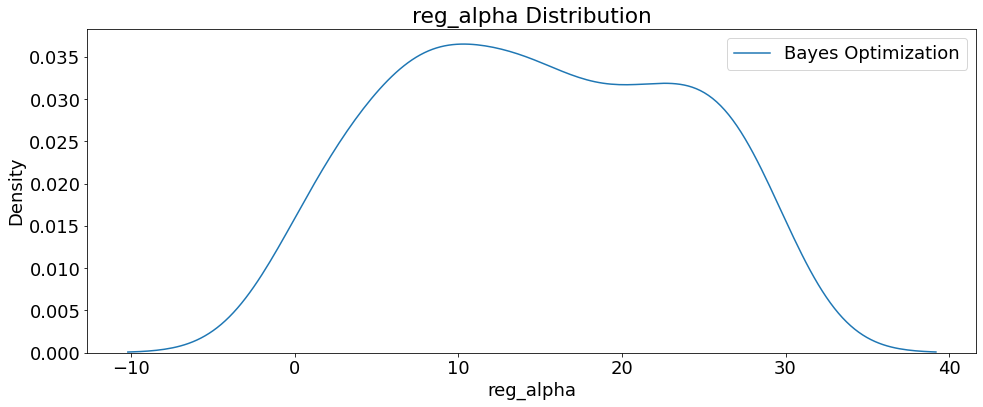

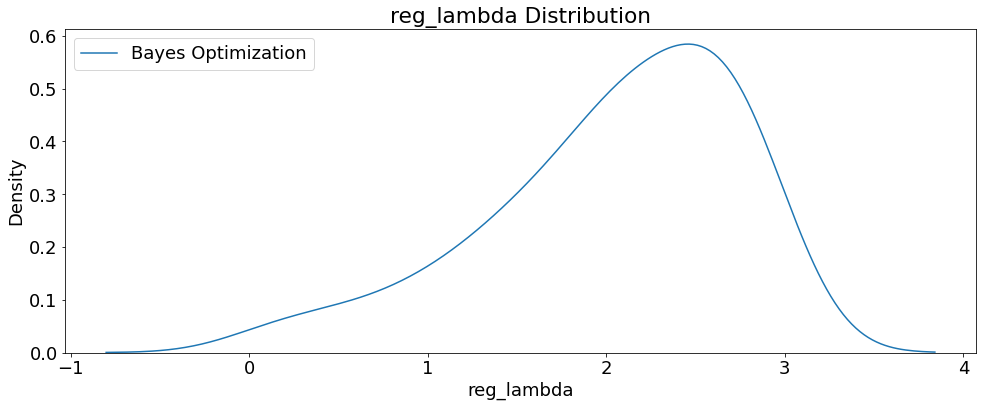

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

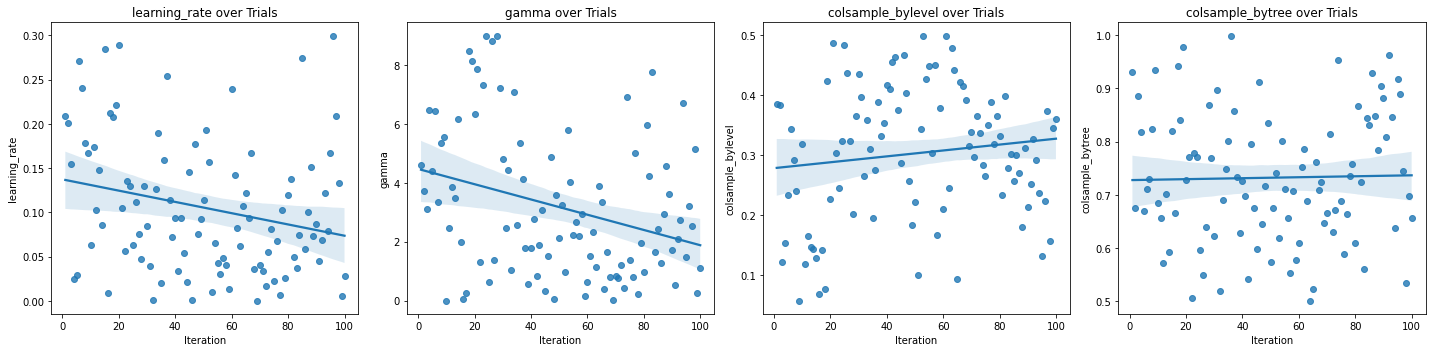

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
    # Scatterplot
    sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
    axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),
    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

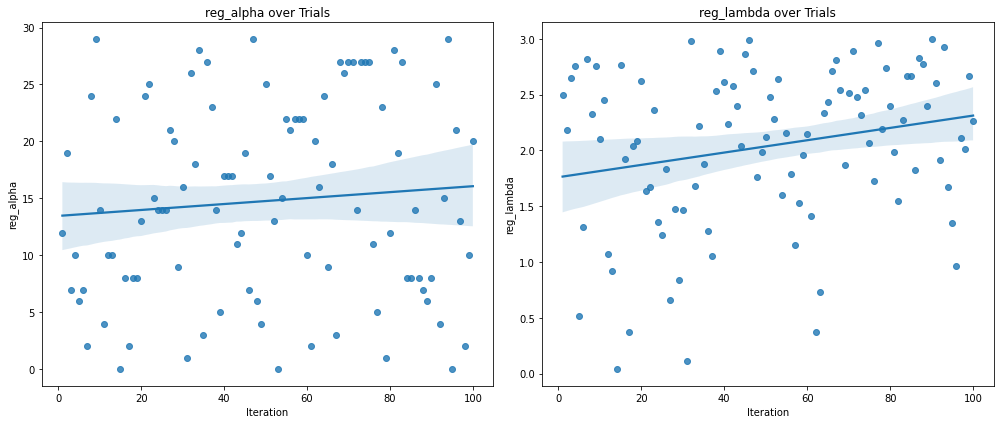

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
    sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
    axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),
    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


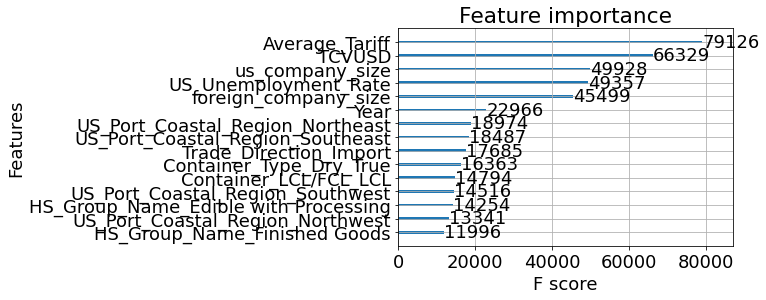

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_train1819_100_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

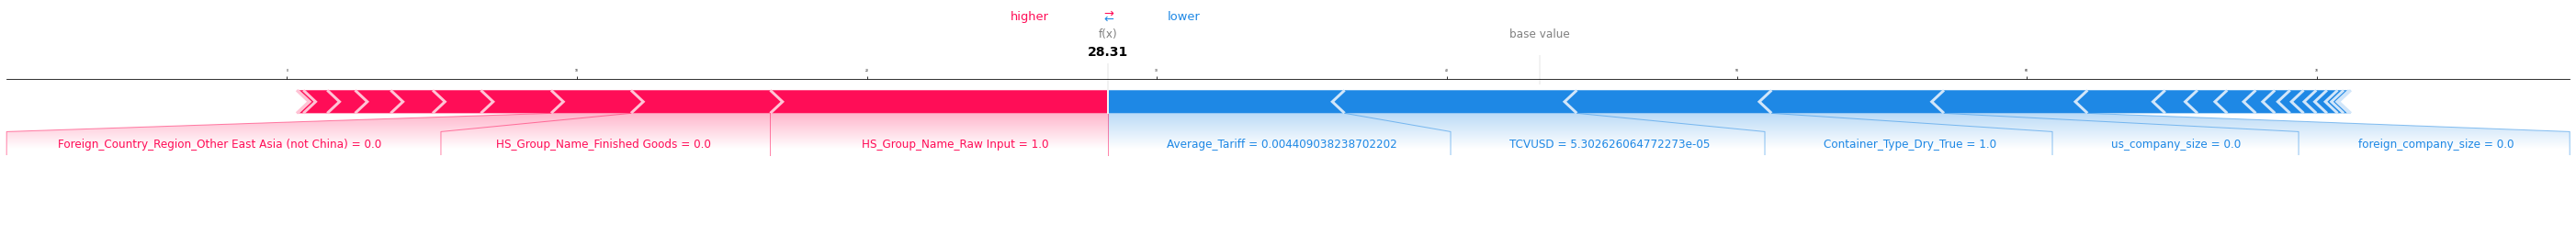

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:],
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_100_GPU_train1819test1819_ShapForcePlot_TrainSet.png',
                                                                     dpi=my_dpi*10,
                                                                     bbox_inches='tight');

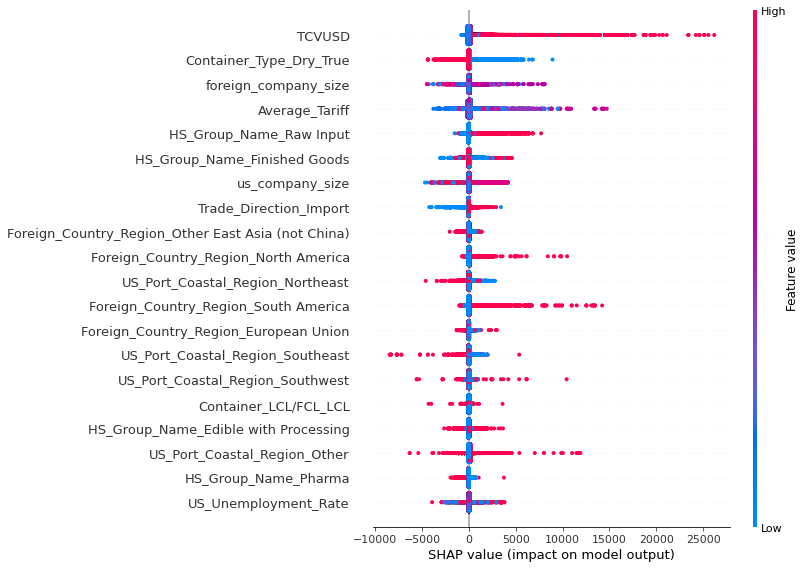

In [ ]:
# Training Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
fig.savefig('XGBoost_HPO_300_GPU_train1819test1819_ShapSummary_TrainSet.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

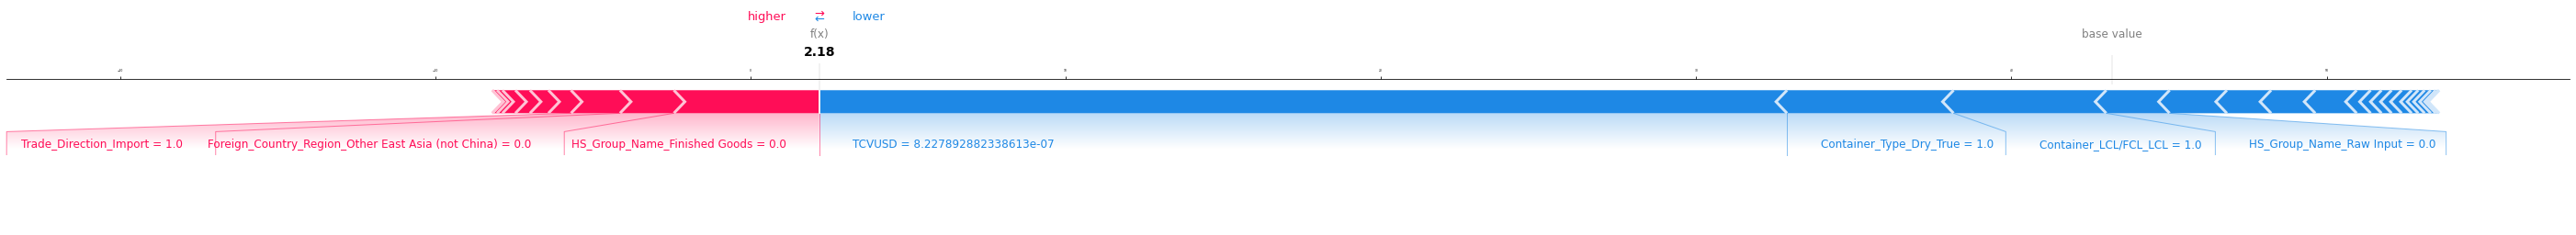

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:],
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_100_GPU_train1819test1819_ShapForcePlot_TestSet.png',
                                                                     dpi=my_dpi*10,
                                                                     bbox_inches='tight');

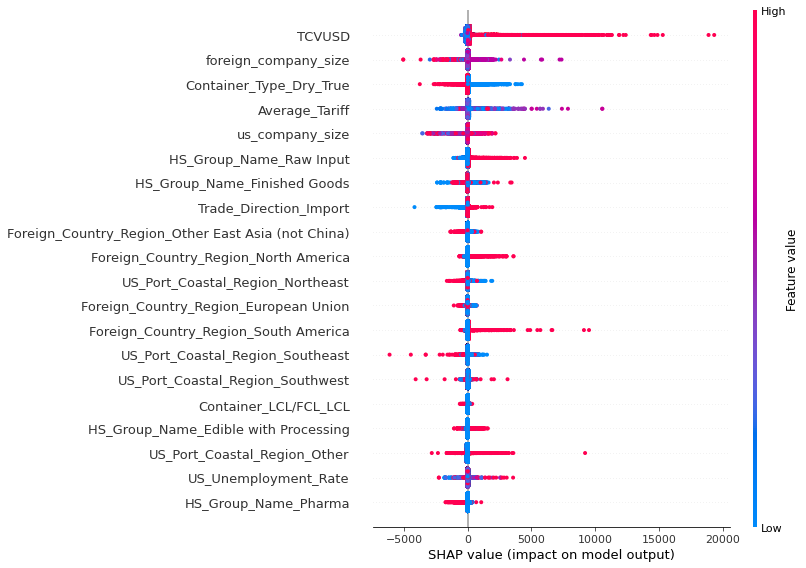

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
fig.savefig('XGBoost_HPO_100_GPU_train1819test1819_ShapSummary_TestSet.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test, columns=X_test.columns)

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test1.columns.tolist())

# Write feature weights html object to a file
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train1819_HPO_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train1819_HPO_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train1819_HPO_100_GPU_WeightsExplain.csv', index=False)
exp

feature    weight       std
0                                              TCVUSD  0.549683  0.004836
1                                      Average_Tariff  0.302772  0.009556
2                             Container_Type_Dry_True  0.243435  0.011454
3                             HS_Group_Name_Raw Input  0.110186  0.004086
4                                foreign_company_size  0.092612  0.003602
5                              Trade_Direction_Import  0.083315  0.003095
6                        HS_Group_Name_Finished Goods  0.081315  0.004040
7                    US_Port_Coastal_Region_Northwest  0.051079  0.004663
8                Foreign_Country_Region_South America  0.044560  0.003276
9                        US_Port_Coastal_Region_Other  0.034288  0.001026
10  Foreign_Country_Region_Other Europe (not Europ...  0.033949  0.003158
11                   US_Port_Coastal_Region_Southeast  0.028717  0.008737
12               Foreign_Country_Region_North America  0.027920  0.001562
13  Foreign_Country_Region_Other East Asia (not Ch...  0.027205  0.001757
14                                               Year  0.023985  0.003062
15                   US_Port_Coastal_Region_Northeast  0.019225  0.005422
16               HS_Group_Name_Edible with Processing  0.018566  0.002232
17              Foreign_Country_Region_Southeast Asia  0.016626  0.001525
18                   US_Port_Coastal_Region_Southwest  0.016057  0.006081
19                               HS_Group_Name_Pharma  0.015528  0.000627

### Test trained 2018-19 model on 2020

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final.csv', low_memory=False)
df = df.drop_duplicates()
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna()
        & df.State_Closure_EA_Diff.notna()]
print('Number of rows and columns:', df.shape)

Number of rows and columns: (26017713, 20)


In [ ]:
# Filter df to 2020
df = df[df['Year'] == 2020]

# Prepare 2020 to fit model train on 2019
X_test1 = df.drop(['Metric_Tons', 'DateTime'], axis=1)
y_test1 = df['Metric_Tons']

del df

# Testing set: Encode variables using ranking - ordinal
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

# Test: Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

# MinMax Scaling
mn = MinMaxScaler()
X_test1 = pd.DataFrame(mn.transform(X_test1), columns=X_test1.columns)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Fit the model
best_bayes_model_fit(X_test1, y_test1)

# Model Metrics
print('\nModel Metrics for XGBoost HPO Train 2018-19 Test 2020')
y_test_pred = best_bayes_model.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test1, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test1, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test1, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test1, y_test_pred)))


Model Metrics for XGBoost HPO Train 2018-19 Test 2020
MAE train: 19.136, test: 5.537
MSE train: 73281.525, test: 133.680
RMSE train: 270.706, test: 11.562
R^2 train: 0.796, test: 0.785


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


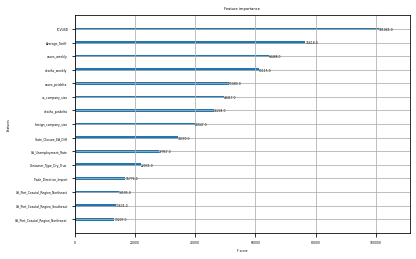

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_train1819test20_100_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test1)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

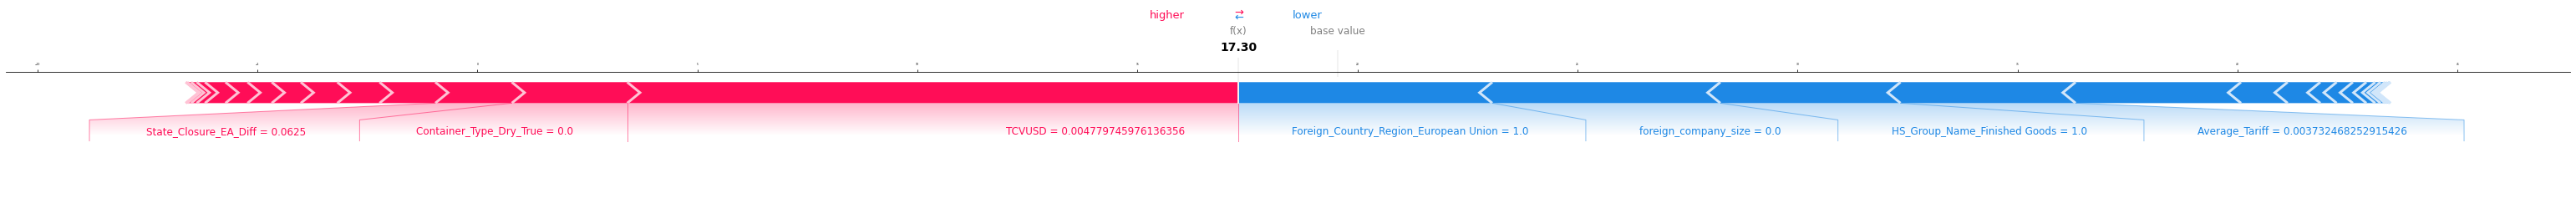

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:],
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_100_GPU_train1819test20_ShapForcePlot_TestSet.png',
                                                                     dpi=my_dpi*10,
                                                                     bbox_inches='tight');

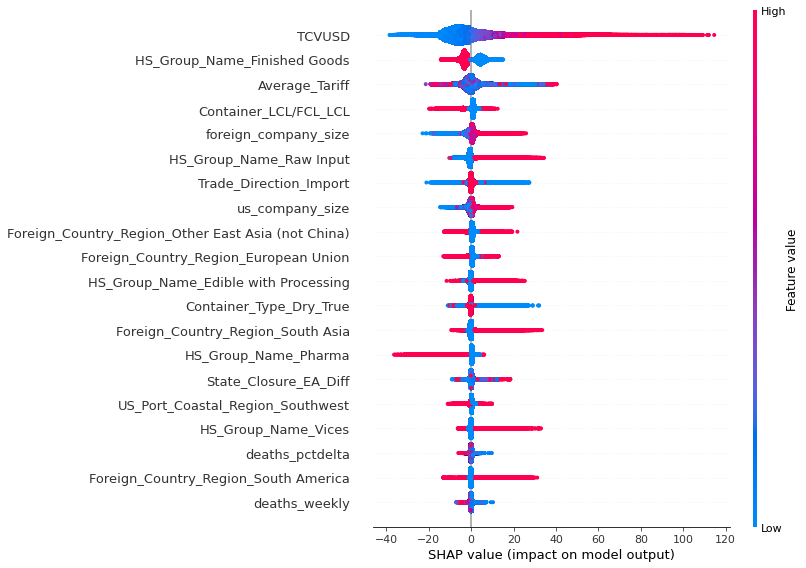

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test1, show=False)
fig.savefig('XGBoost_HPO_100_GPU_train1819test20_ShapSummary_TestSet.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test1,
                                                                     y_test1)

In [ ]:
# Store feature weights in an object
X_test2 = pd.DataFrame(X_test1, columns=X_test1.columns)

html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test2.columns.tolist())

# Write feature weights html object to a file
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train1819test20_HPO_100_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train1819test20_HPO_100_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test2.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train1819test20_HPO_100_GPU_WeightsExplain.csv',
           index=False)
exp

feature    weight       std
0                                              TCVUSD  0.926892  0.000426
1                                      Average_Tariff  0.281621  0.000281
2                    US_Port_Coastal_Region_Southeast  0.115484  0.000142
3                    US_Port_Coastal_Region_Northwest  0.113761  0.000248
4                              Trade_Direction_Import  0.107322  0.000293
5                                     us_company_size  0.076323  0.000209
6                                                Year  0.075124  0.000226
7                             Container_Type_Dry_True  0.052019  0.000285
8                    US_Port_Coastal_Region_Northeast  0.045917  0.000107
9   Foreign_Country_Region_Other Europe (not Europ...  0.039370  0.000128
10                              State_Closure_EA_Diff  0.038908  0.000152
11          Foreign_Country_Region_Sub Saharan Africa  0.036187  0.000089
12                               HS_Group_Name_Pharma  0.031053  0.000137
13                              Container_LCL/FCL_LCL  0.027511  0.000085
14                                      deaths_weekly  0.025281  0.000033
15                       US_Port_Coastal_Region_Other  0.024645  0.000049
16                   US_Port_Coastal_Region_Southwest  0.021945  0.000034
17                                       cases_weekly  0.019888  0.000052
18                       HS_Group_Name_Finished Goods  0.019156  0.000089
19                            HS_Group_Name_Raw Input  0.018607  0.000077

## 300 Trials 10-Fold Cross Validation

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final.csv', low_memory=False)
df = df.drop_duplicates()
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna()
        & df.State_Closure_EA_Diff.notna()]

# Subset years for training
df = df.loc[(df['Year'] >= 2018) & (df['Year'] < 2020)]

# Examine distribution of year data
df[['Year']].value_counts()

Year  
2018.0    3080375
2019.0    2978984
dtype: int64

In [ ]:
# X,y for encoding
X = df.drop(['Metric_Tons', 'DateTime'], axis=1)
y = df.loc[:, ['Metric_Tons']]

del df

In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=X.Year,
                                                    random_state=seed_value)

In [ ]:
# Encode variables using ranking - ordinal
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_train = ce_ord.fit_transform(X_train)
X_test = ce_ord.fit_transform(X_test)

# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# MinMax Scaling
mn = MinMaxScaler()
X_train = pd.DataFrame(mn.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(mn.transform(X_test), columns=X_test.columns)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions


In [ ]:
# Define the number of trials
NUM_EVAL = 300

# File to save first results
out_file = 'XGB_HPO_train1819_300_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials
# Start timer for experiment
start_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                  max_evals=NUM_EVAL, trials=bayesOpt_trials,
                  rstate=np.random.RandomState(42))

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Start Time           2022-02-18 12:57:51.433378
100%|██████████| 300/300 [19:52:13<00:00, 238.45s/it, best loss: 347.1735679549237]
Start Time           2022-02-18 12:57:51.433378
End Time             2022-02-19 08:50:05.290522
19:52:13


In [ ]:
# Sort the trials with lowest loss (lowest RMSE) first
bayesOpt_trials_results = sorted(bayesOpt_trials.results,
                                 key=lambda x: x['loss'])
print('Top two trials with the lowest loss (lowest RMSE)')
print(bayesOpt_trials_results[:2])

Top two trials with the lowest loss (lowest RMSE)
[{'loss': 347.1735679549237, 'params': {'colsample_bylevel': 0.4346153391162512, 'colsample_bytree': 0.9143839597062742, 'gamma': 5.6215920115676825, 'learning_rate': 0.02034225289813732, 'max_depth': 12, 'min_child_weight': 2, 'n_estimators': 374, 'reg_alpha': 26, 'reg_lambda': 2.3014053584081378, 'subsample': 0.7329540789228473}, 'iteration': 260, 'train_time': 449.9387008699996, 'status': 'ok'}, {'loss': 347.58293491069105, 'params': {'colsample_bylevel': 0.4527482527854778, 'colsample_bytree': 0.8807798245597596, 'gamma': 4.301930495461232, 'learning_rate': 0.026074371472376078, 'max_depth': 12, 'min_child_weight': 2, 'n_estimators': 374, 'reg_alpha': 26, 'reg_lambda': 2.3832916474984085, 'subsample': 0.7499040118005095}, 'iteration': 266, 'train_time': 444.0306954780026, 'status': 'ok'}]


In [ ]:
# Access results
results = pd.read_csv('XGB_HPO_train1819_300_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = XGBRegressor(objective='reg:squarederror',
                                booster='gbtree',
                                tree_method='gpu_hist',
                                scale_pos_weight=1,
                                use_label_encoder=False,
                                random_state=seed_value,
                                verbosity=0,
                                **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_HPO_train1819_300_GPU.pkl'

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_HPO_train1819_300_GPU.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO Train train1819 300 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))


Model Metrics for XGBoost HPO Train train1819 300 GPU trials
MAE train: 17.576, test: 24.110
MSE train: 70994.835, test: 173475.783
RMSE train: 266.449, test: 416.504
R^2 train: 0.802, test: 0.481


In [ ]:
# Evaluate on the testing data
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test,
                                                                                                            y_test_pred)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 173475.77699 MSE on the test set.
This was achieved after 260 search iterations


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0,
                                                                      'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i,:] = list(ast.literal_eval(params).values())

bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_XGB_HPO_train1819_300_GPU.csv',
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

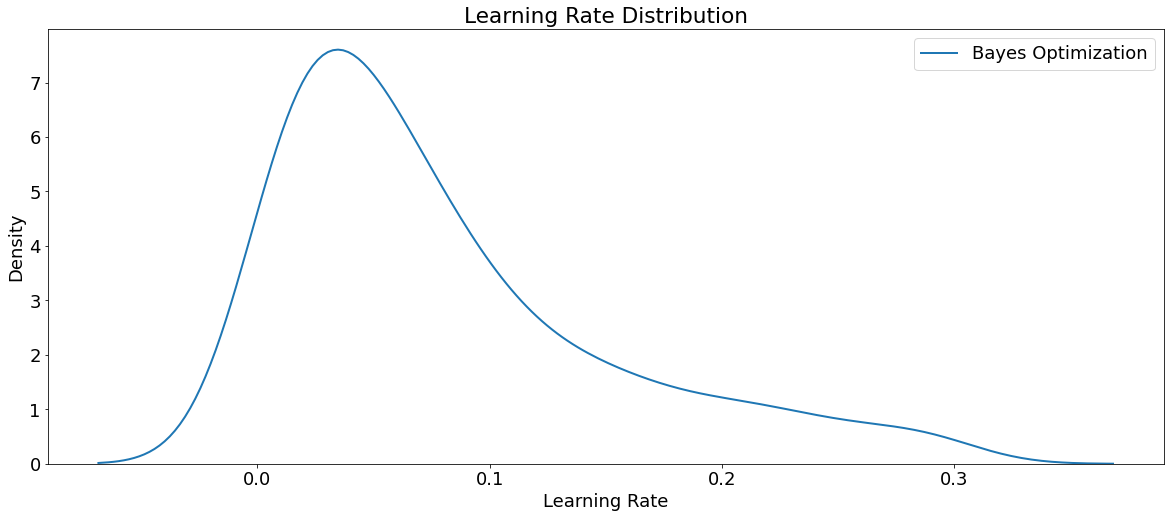

In [ ]:
# Density plots of the learning rate distributions
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization',
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

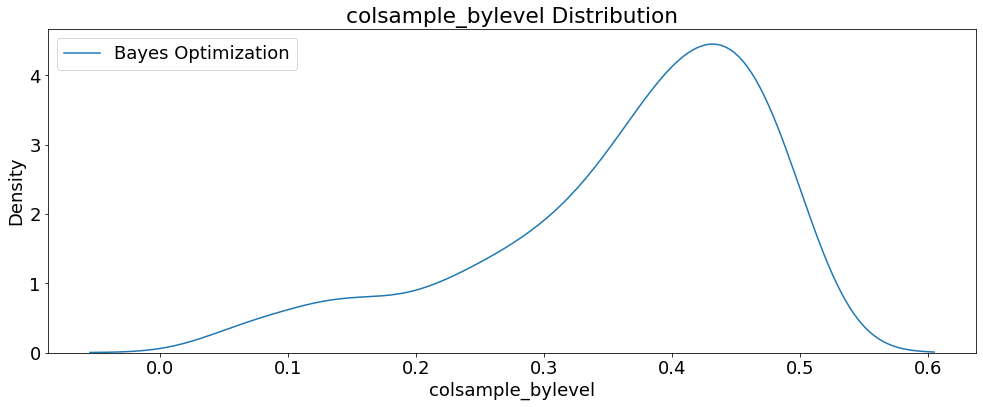

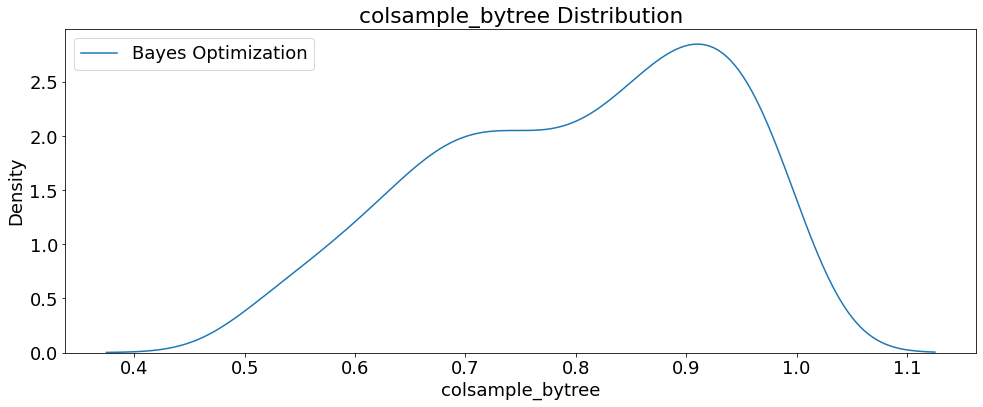

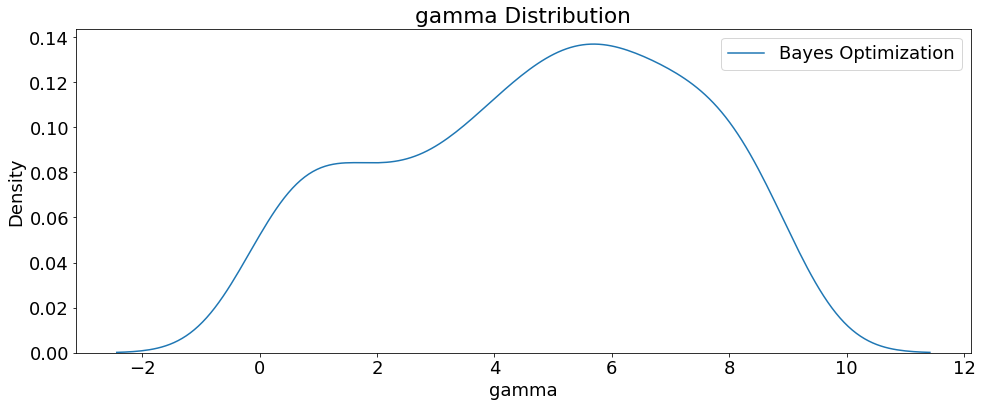

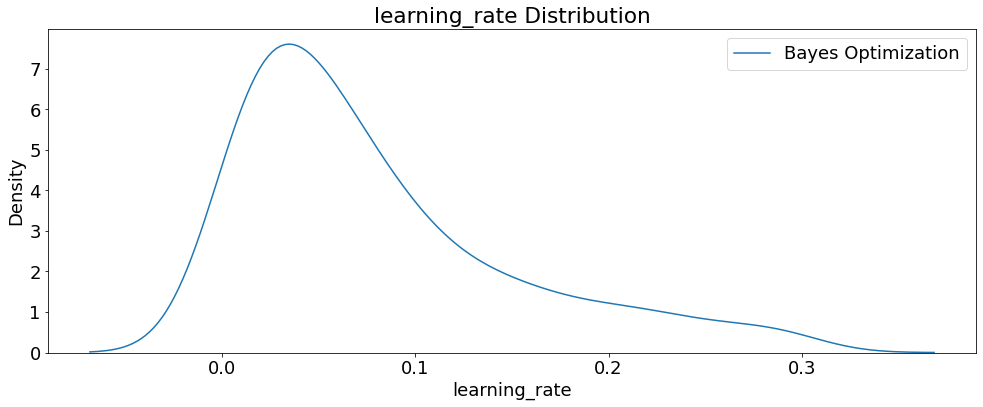

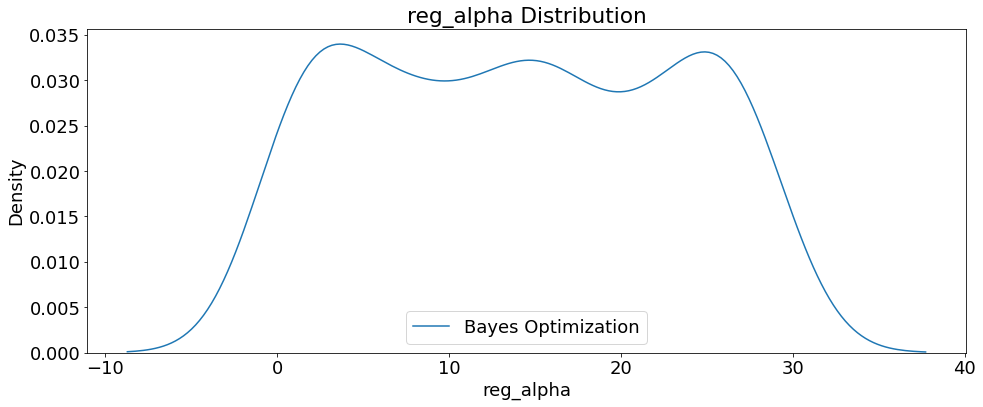

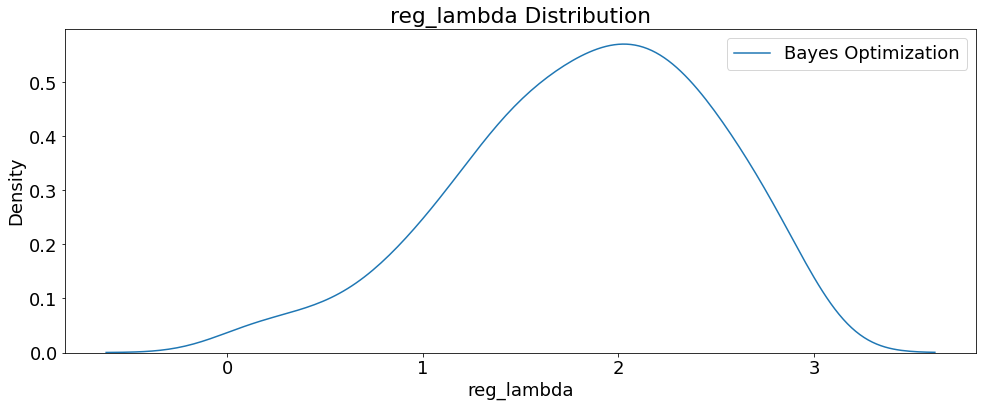

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

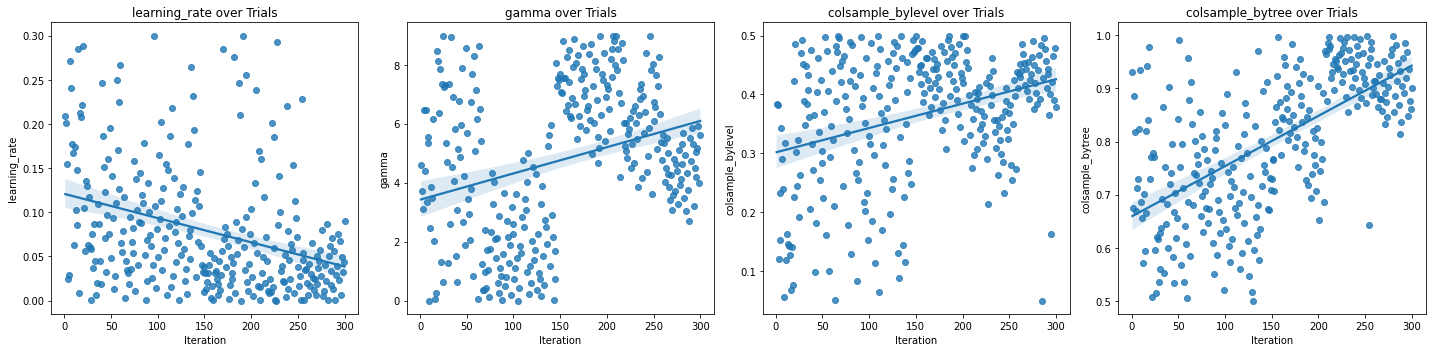

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
    # Scatterplot
    sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
    axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),
    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

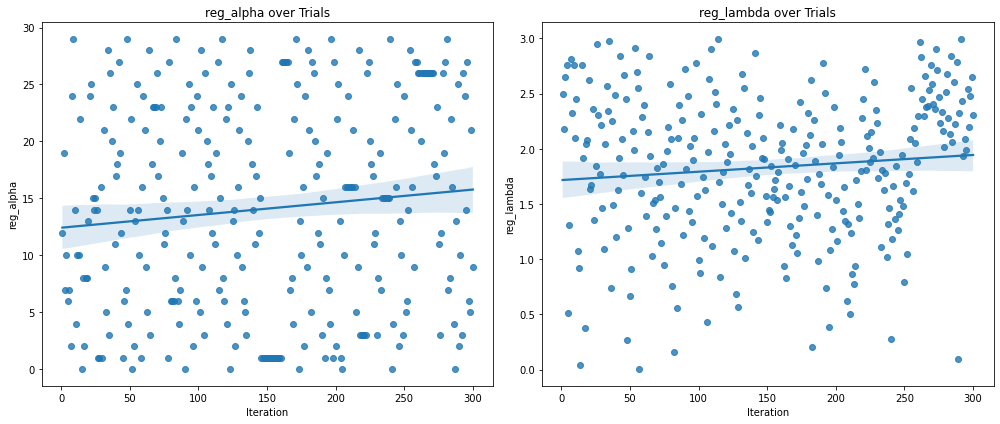

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
    sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
    axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),
    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


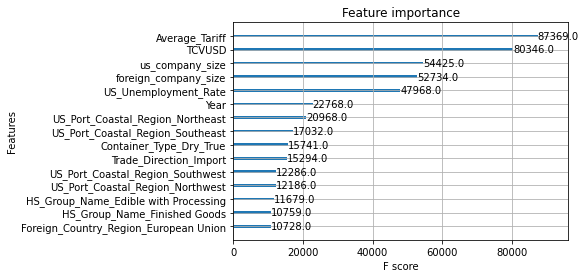

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_train1819_300_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

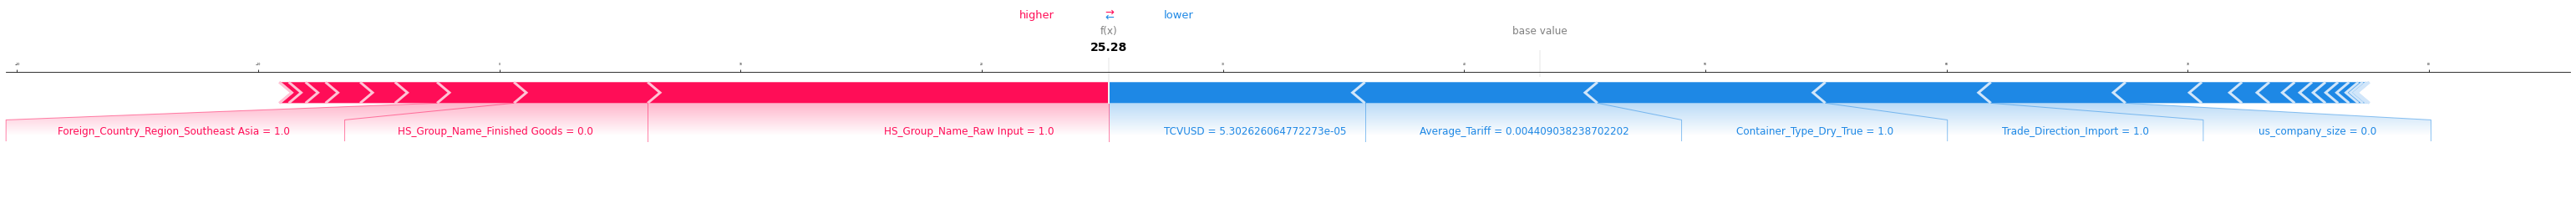

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:],
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_300_GPU_train1819test1819_ShapForcePlot_TrainSet.png',
                                                                     dpi=my_dpi*10,
                                                                     bbox_inches='tight');

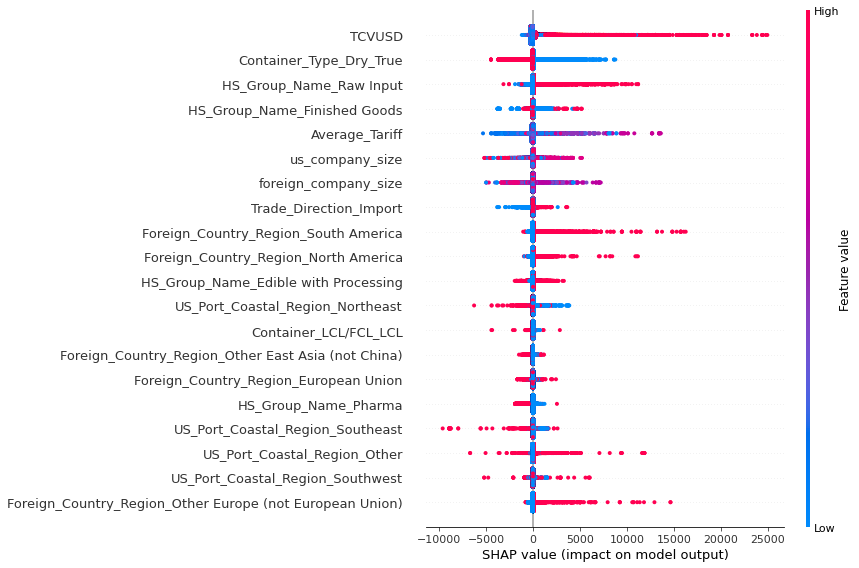

In [ ]:
# Training Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
fig.savefig('XGBoost_HPO_300_GPU_train1819test1819_ShapSummary_TrainSet.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

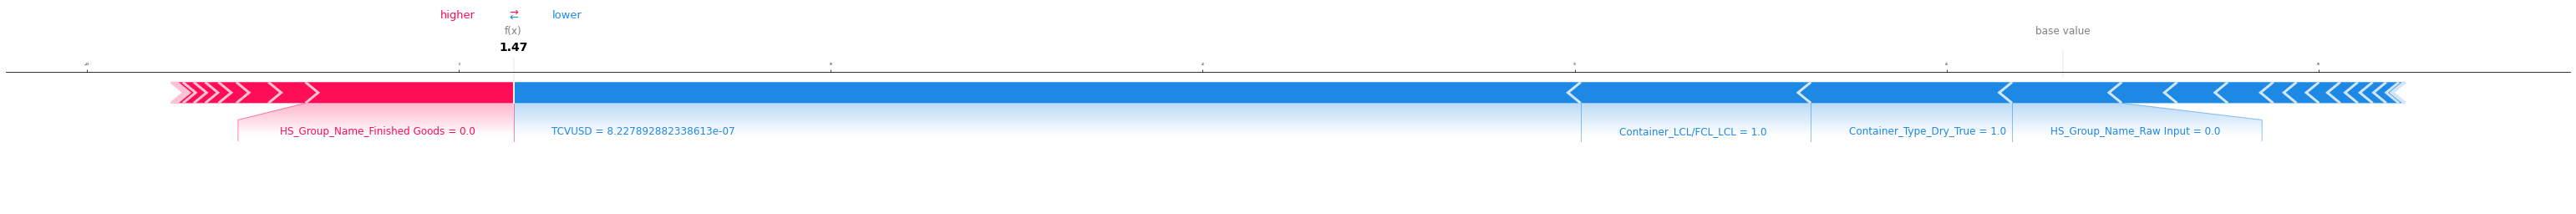

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:],
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_300_GPU_train1819test1819_ShapForcePlot_TestSet.png',
                                                                     dpi=my_dpi*10,
                                                                     bbox_inches='tight');

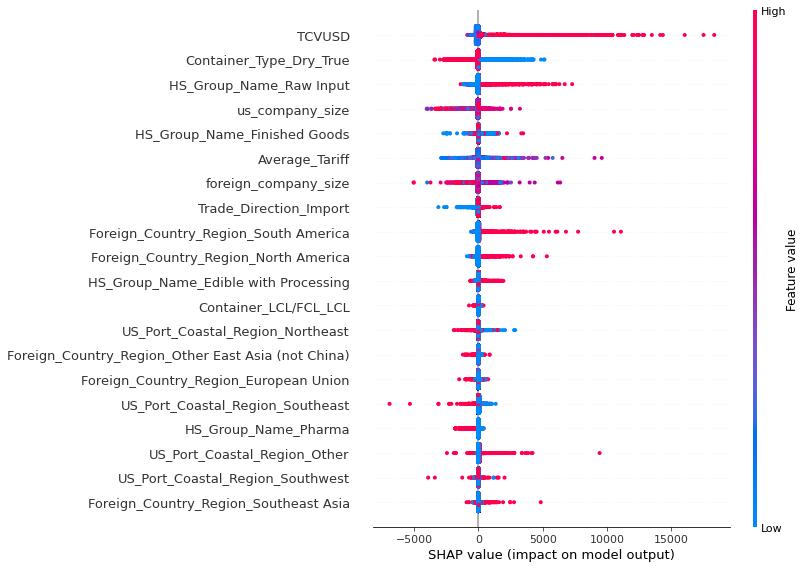

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
fig.savefig('XGBoost_HPO_300_GPU_train1819test1819_ShapSummary_TestSet.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test,
                                                                     y_test)

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test, columns=X_test.columns)

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test1.columns.tolist())

# Write feature weights html object to a file
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train1819_HPO_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train1819_HPO_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train1819_HPO_300_GPU_WeightsExplain.csv', index=False)
exp

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


feature    weight       std
0                                              TCVUSD  0.568959  0.009087
1                             Container_Type_Dry_True  0.263900  0.014665
2                             HS_Group_Name_Raw Input  0.175994  0.004138
3                                      Average_Tariff  0.169113  0.004712
4                Foreign_Country_Region_South America  0.083347  0.003347
5                                foreign_company_size  0.080191  0.003842
6                        HS_Group_Name_Finished Goods  0.068704  0.004577
7                    US_Port_Coastal_Region_Northwest  0.057873  0.005223
8   Foreign_Country_Region_Other Europe (not Europ...  0.039187  0.005607
9                              Trade_Direction_Import  0.037289  0.002427
10                   US_Port_Coastal_Region_Southeast  0.036355  0.010242
11               HS_Group_Name_Edible with Processing  0.032280  0.002721
12                       US_Port_Coastal_Region_Other  0.030002  0.000902
13                   US_Port_Coastal_Region_Northeast  0.027713  0.007602
14                               HS_Group_Name_Pharma  0.025072  0.000265
15                                               Year  0.023350  0.003819
16  Foreign_Country_Region_Other East Asia (not Ch...  0.015547  0.000950
17              Foreign_Country_Region_Southeast Asia  0.014888  0.001820
18               Foreign_Country_Region_North America  0.014536  0.002225
19                                HS_Group_Name_Vices  0.013203  0.003958

### Test trained 2018-19 model on 2020

In [ ]:
%cd /content/drive/MyDrive/MaritimeTrade/Data/

/content/drive/MyDrive/MaritimeTrade/Data


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final.csv', low_memory=False)
df = df.drop_duplicates()
df = df[df.Foreign_Country_Region.notna() & df.Average_Tariff.notna()
        & df.State_Closure_EA_Diff.notna()]
print('Number of rows and columns:', df.shape)

Number of rows and columns: (26017713, 20)


In [ ]:
# Filter df to 2020
df = df[df['Year'] == 2020]

# Prepare 2020 to fit model train on 2019
X_test1 = df.drop(['Metric_Tons', 'DateTime'], axis=1)
y_test1 = df['Metric_Tons']

del df

# Testing set: Encode variables using ranking - ordinal
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

# Test: Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

# MinMax Scaling
mn = MinMaxScaler()
X_test1 = pd.DataFrame(mn.transform(X_test1), columns=X_test1.columns)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Fit the model
best_bayes_model.fit(X_test1, y_test1)

# Model Metrics
print('\nModel Metrics for XGBoost HPO Train 2018-19 Test 2020')
y_test_pred = best_bayes_model.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test1, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test1, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test1, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test1, y_test_pred)))


Model Metrics for XGBoost HPO Train 2018-19 Test 2020
MAE train: 17.576, test: 5.650
MSE train: 70994.835, test: 142.133
RMSE train: 266.449, test: 11.922
R^2 train: 0.802, test: 0.771


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


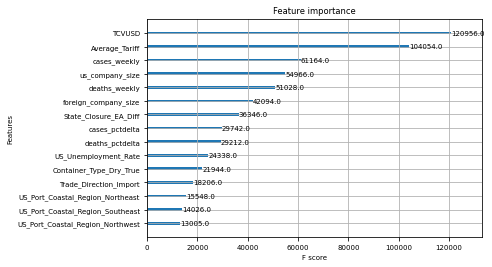

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('XGBoost_HPO_train1819test20_300_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(X_test1)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


<Figure size 432x288 with 0 Axes>

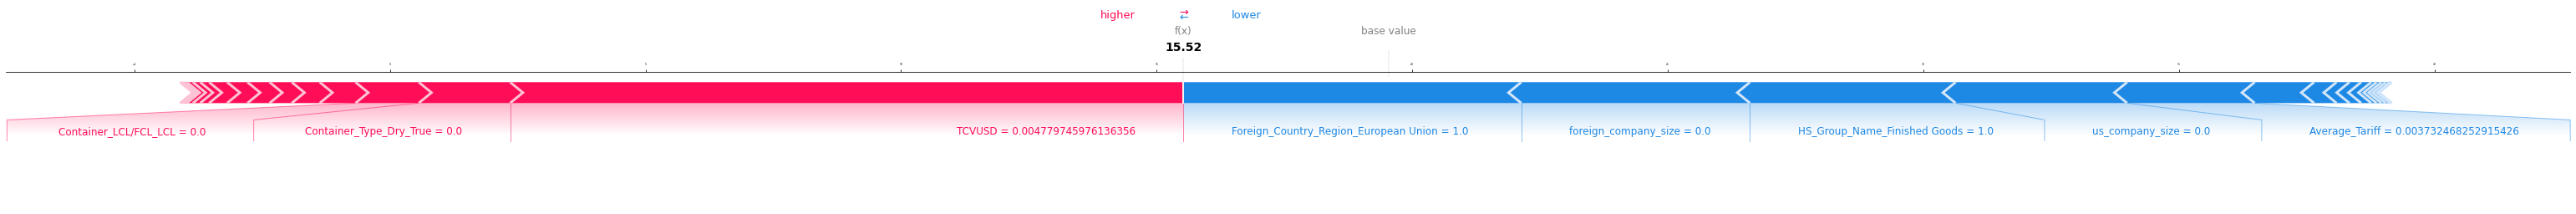

In [ ]:
# Visualize the first prediction's explanation
plt.rcParams.update({'font.size': 3})
fig = plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test1.iloc[0,:],
                show=False, matplotlib=True, figsize=(55,3)).savefig('XGBoost_HPO_300_GPU_train1819test20_ShapForcePlot_TestSet.png',
                                                                     dpi=my_dpi*10,
                                                                     bbox_inches='tight');

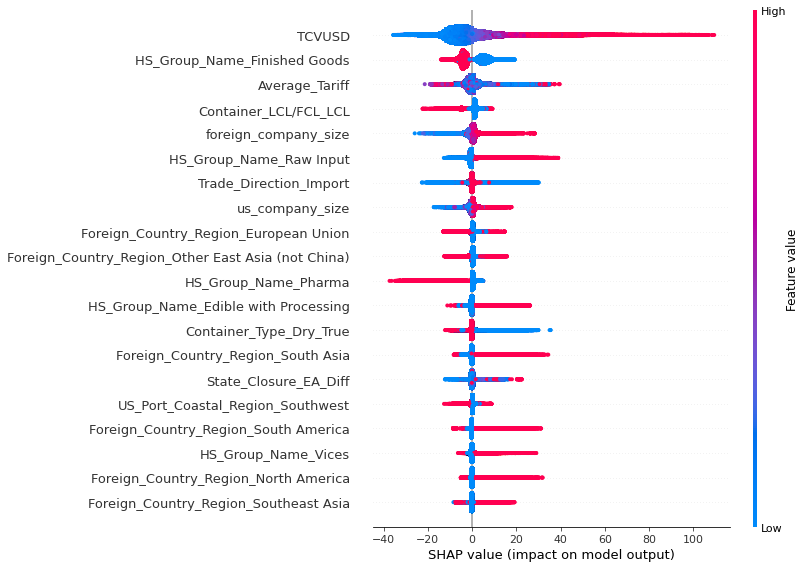

In [ ]:
# Test Set: Summarize the effects of all the features
plt.rcParams.update({'font.size': 7})
fig = plt.figure()
shap.summary_plot(shap_values, X_test1, show=False)
fig.savefig('XGBoost_HPO_300_GPU_train1819test20_ShapSummary_TestSet.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test1,
                                                                     y_test1)

In [ ]:
# Store feature weights in an object
X_test2 = pd.DataFrame(X_test1, columns=X_test1.columns)

html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test2.columns.tolist())

# Write feature weights html object to a file
with open(r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train1819test20_HPO_300_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_train1819test20_HPO_300_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test2.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_train1819test20_HPO_300_GPU_WeightsExplain.csv',
           index=False)